<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#局部回归" data-toc-modified-id="局部回归-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>局部回归</a></span></li><li><span><a href="#数据" data-toc-modified-id="数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据</a></span><ul class="toc-item"><li><span><a href="#非自适应方法" data-toc-modified-id="非自适应方法-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>非自适应方法</a></span></li><li><span><a href="#自适应方法" data-toc-modified-id="自适应方法-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>自适应方法</a></span></li></ul></li><li><span><a href="#二维" data-toc-modified-id="二维-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>二维</a></span><ul class="toc-item"><li><span><a href="#非自适应方法" data-toc-modified-id="非自适应方法-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>非自适应方法</a></span></li><li><span><a href="#自适应方法" data-toc-modified-id="自适应方法-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>自适应方法</a></span></li></ul></li></ul></div>

# 局部回归

支持多个features

支持三种核（权重函数）

* 两重三次函数 $(1-((x-x_0)/R)^3 )^3$
* 均匀 $1$ $|x-x_0|<R$
* 高斯 $\exp(-\gamma (x-x_0)^2)$

支持局部回归策略：

* 平均, degree = 0
* 线性, degree = 1
* 高次函数, degree > 1

支持自适应，首选从数据选取$x_0$最近邻的$k= \alpha N_{\rm train}$个点，然后计算他们最大距离$R=\max_{0\leq i<k} |x_i - x_0|$，而$\gamma = 1/(2R^2)$。

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import pairwise_distances

class LocalRegressor:

    
    def __init__(self, degree=0, kernel="tri-cube", radius=1, gamma=1, adaptive=False, alpha=0.1):
        '''
        Parameters
        ----------
        degree:   int, degree of polynominal
        kernel:   str,  `tri-cube` `uniform` or `gaussian`
        radius:   float, used only for uniform and tri-cube kernel
            only |x < x_0| are taken into account, and tri-cube(x, x0) = (1-(|x-x0|/radius)^3)^3
        gamma:    float, used only for gaussian kernel, gaussian(x, y) = exp(-gamma*(x-y)^2)
        adaptive: boolean, radius and gamma are culculated from data
        alpha:  float, used only when adaptive set True,
            For k = ceil(alpha*N_train) nearest neighbors
            radius is calculated by max_{0<=i<k} |x_i-x0|
            gamma is calculated by 1/(2 radius^2)        
        '''
        
        self.degree = degree
        self.kernel = kernel        
        self.radius = radius
        self.gamma =  gamma
        self.adaptive = adaptive
        self.alpha = alpha

    
    def get_params(self, deep=False):
        return {
            "degree": self.degree,
            "kernel": self.kernel,
            "radius": self.radius,
            "gamma": self.gamma,
            "adaptive": self.adaptive,
            "alpha": self.alpha,
        }
    
    def set_params(self, **kargs):
        for key in kargs:
            if key == "degree":
                self.degree = kargs[key]
            elif key == "kernel":
                self.kernel = kargs[key]
            elif key == "radius":
                self.radius = kargs[key]
            elif key == "gamma":
                self.gamma = kargs[key]
            elif key == "adaptive":
                self.adaptive = kargs[key]
            elif key == "alpha":
                self.alpha = kargs[key]
            else:
                raise(Exception("uknown parameter%s"%key))
        return self
        
    def __repr__(self):
        return "LocalLinearRegression(kernel='%s', radius=%f, gamma=%f, alpha=%.2E, adaptive=%d, degree=%d)"%\
                    (self.kernel, self.radius, self.gamma, self.alpha, self.adaptive, self.degree)
    
    def score(self, X, y):
        yhat = self.predict(X)
        return -np.max(np.abs(y-yhat))
    
    def fit(self, X, y):
        
        if self.degree >= 1:
            self.lr = LinearRegression()   
        
        if self.degree >= 2:
            self.tr = PolynomialFeatures(degree=self.degree, include_bias=False)
            self.Xtr = self.tr.fit_transform(X)
        else:
            self.Xtr = X
            
        if self.adaptive:
            N_neighbors = np.ceil(self.alpha*np.shape(X)[0]).astype(int)
            self.nn = NearestNeighbors(n_neighbors=N_neighbors)
        else:
            if self.kernel == "tri-cube" or self.kernel == "uniform":
                self.nn = NearestNeighbors(n_neighbors=1, radius=self.radius)
            elif self.kernel == "gaussian":
                self.nn = None
        
        if self.nn is not None:
            self.nn.fit(X)
            
        self.X = X
        self.y = y
        
    def predict(self, X):
        
        X = np.array(X)
        
        if self.degree >= 2:
            Xtr = self.tr.transform(X)
        else:
            Xtr = X
            
        
        kernel = self.kernel                                
        nn = self.nn
        
        # calculate radius and gammas for kernel
        # we did a quick calculation for degree == 0
        if self.adaptive:
            # find near in original space
            Dist, X_indices = nn.kneighbors(X, return_distance=True)
            radii = Dist.max(axis=1, keepdims=True) * (1+1E-10) + 1E-10
            
            if kernel == "tri-cube":
                
                # weight can't be zero
                if self.degree == 0:
                    weights = (1 - np.abs(Dist/radii)**3)**3    
                    y_nb = self.y[X_indices]
                    yhat = (y_nb*weights).sum(axis=1) / weights.sum(axis=1)
                    return yhat
                
            elif kernel == "uniform":
                if self.degree == 0:
                    y_nb = self.y[X_indices]
                    yhat = y_nb.mean(axis=1)
                    return yhat
                    
            elif kernel == "gaussian":
                gammas = 1./(2*radii**2)
                if self.degree == 0:
                    weights = np.exp(-gammas*Dist**2)   
                    y_nb = self.y[X_indices]
                    yhat = (y_nb*weights).sum(axis=1) / weights.sum(axis=1)
                    return yhat
                    
        else:
            # find near in original space
            if nn is not None:
                Dist, X_indices = nn.radius_neighbors(X, return_distance=True)

        yhat = np.zeros(Xtr.shape[0])
        
        if kernel is "gaussian":
            
            distance =  pairwise_distances(X, self.X)
            if self.adaptive:                
                weights = np.exp(-gammas*distance**2)
            else:
                weights = np.exp(-self.gamma*distance**2)
                
            if self.degree == 0:
                yhat = (self.y * weights).sum(axis=1) / weights.sum(axis=1)
            else:
                for x_i in range(len(X)):
                    self.lr.fit(self.Xtr, self.y, weights[x_i])
                    yhat[x_i] = self.lr.predict(Xtr[x_i:x_i+1])[0]
                            
        else:
            for x_i, x_indices in enumerate(X_indices):

                if len(x_indices) < 1:
                    # no indicies ?
                    # try to get 1
                    X_indicies = nn.kneighbors(X[x_i:x_i+1], return_distance=False)
                    x_index = X_indicies[0]
                    yhat[x_i] = self.y[x_index]
                else:
                    y_nb = self.y[x_indices]
                    xtr_nb = self.Xtr[x_indices]
                    dist = Dist[x_i]

                    if kernel == "tri-cube":

                        if self.adaptive:
                            radius_ = radii[x_i]
                        else:
                            radius_ = self.radius

                        weights = (1 - np.abs(dist/radius_)**3)**3

                        if self.degree >= 1:
                            self.lr.fit(xtr_nb, y_nb, weights)
                            yhat[x_i] = self.lr.predict([Xtr[x_i]])
                        else:
                            yhat[x_i] = (y_nb * weights).sum(axis=0)/ weights.sum()

                    elif kernel == "uniform":

                        if self.degree >= 1:
                            self.lr.fit(xtr_nb, y_nb)
                            yhat[x_i] = self.lr.predict([Xtr[x_i]])
                        else:
                            yhat[x_i] = y_nb.mean()
                        
        

        return yhat
        
    

# 数据

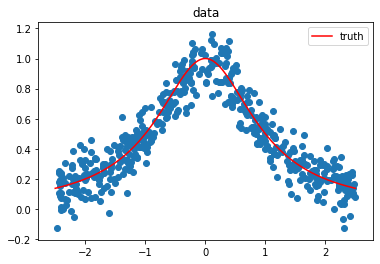

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def f(X):
    return 1 / (1 + (X[:,0])**2) 

SIGMA=0.1
N_train = 500
np.random.seed(0)

X = 5*(np.random.rand(N_train, 1) - 0.5)
y = f(X) + SIGMA*np.random.randn(N_train)
X_plt = 5*(np.linspace(0,1,N_train) - 0.5).reshape(-1,1)

plt.plot(X_plt, f(X_plt), label="truth", color="red")
plt.scatter(X, y)

plt.title("data")
plt.legend()
plt.show()

def plot1D(model, ax):
    model.fit(X, y)
    yhat= model.predict(X_plt)
    if model.adaptive:
        ax.set_title(r"%s,degree=%d,adaptive,$\alpha$=%.1f"%(model.kernel, model.degree, model.alpha))
    else:
        if model == "gaussian":
            ax.set_title(r"%s,degree=%d,non-adaptive,$\gamma$=%.1f"%(model.kernel, model.degree, model.gamma))
        else:
            ax.set_title(r"%s,degree=%d,non-adaptive,$r$=%.1f"%(model.kernel, model.degree, model.radius))
    ax.plot(X_plt, f(X_plt), label="truth", color="red")
    ax.plot(X_plt, yhat, label="predict")
    ax.legend()


## 非自适应方法

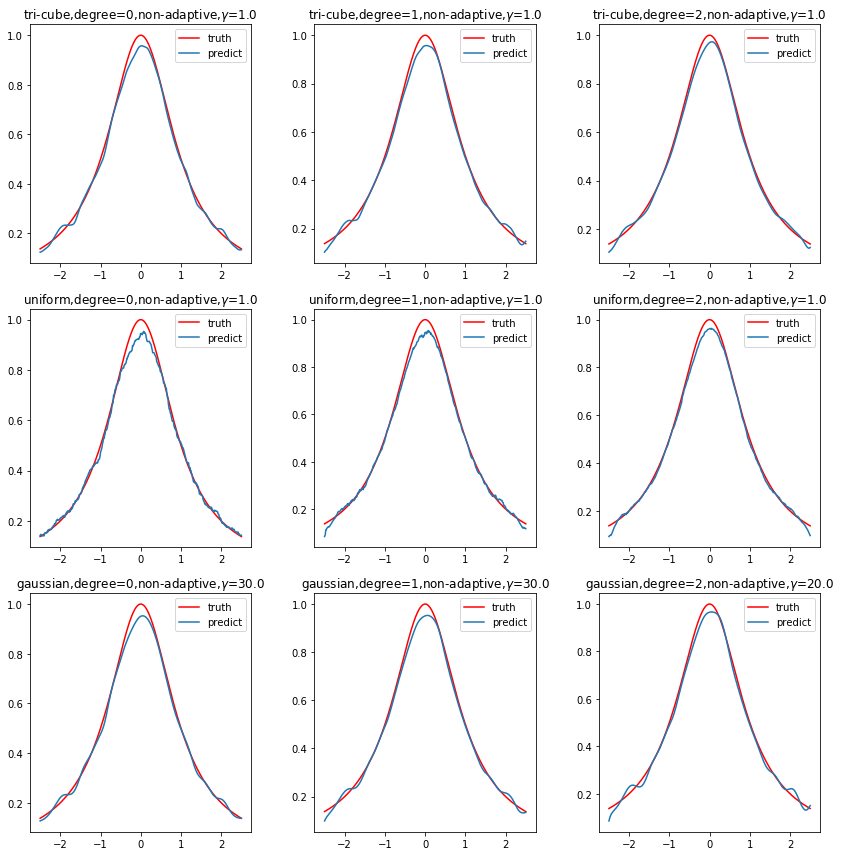

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

plot1D(LocalRegressor(degree=0, kernel="tri-cube", radius=0.3), ax = axes[0,0])
plot1D(LocalRegressor(degree=1, kernel="tri-cube", radius=0.3), ax = axes[0,1])
plot1D(LocalRegressor(degree=2, kernel="tri-cube", radius=0.7), ax = axes[0,2])
plot1D(LocalRegressor(degree=0, kernel="uniform", radius=0.3), ax = axes[1,0])
plot1D(LocalRegressor(degree=1, kernel="uniform", radius=0.3), ax = axes[1,1])
plot1D(LocalRegressor(degree=2, kernel="uniform", radius=0.7), ax = axes[1,2])
plot1D(LocalRegressor(degree=0, kernel="gaussian", gamma=30), ax = axes[2,0])
plot1D(LocalRegressor(degree=1, kernel="gaussian", gamma=30), ax = axes[2,1])
plot1D(LocalRegressor(degree=2, kernel="gaussian", gamma=20), ax = axes[2,2])

plt.tight_layout()
plt.show()

## 自适应方法

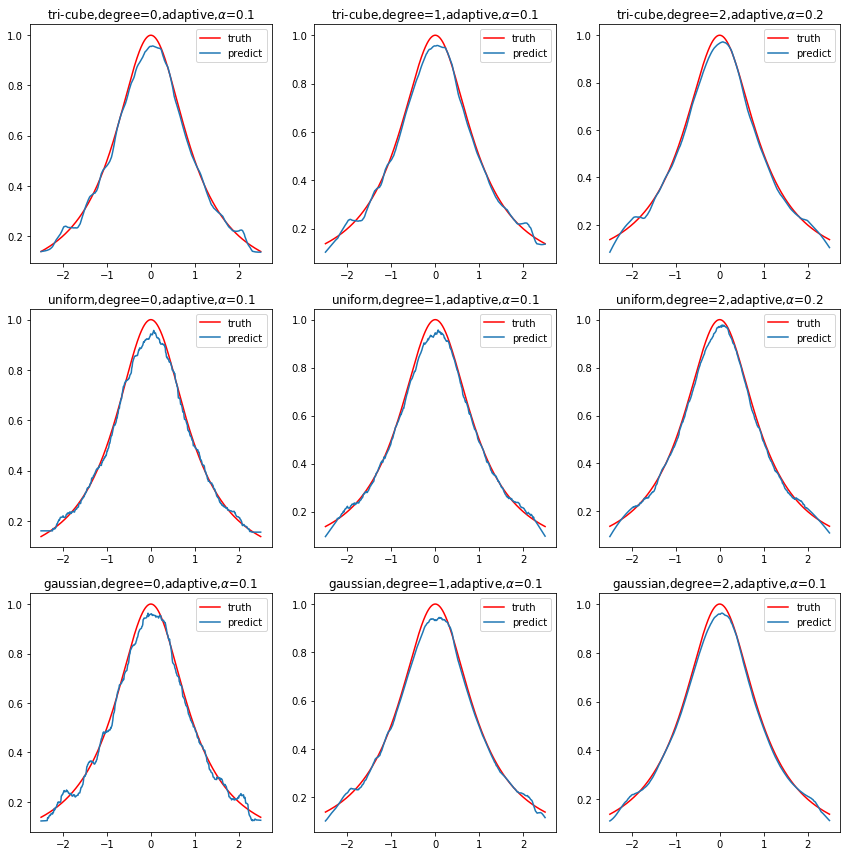

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

plot1D(LocalRegressor(degree=0, kernel="tri-cube", adaptive=True, alpha=0.1), ax = axes[0,0])
plot1D(LocalRegressor(degree=1, kernel="tri-cube", adaptive=True, alpha=0.1), ax = axes[0,1])
plot1D(LocalRegressor(degree=2, kernel="tri-cube", adaptive=True, alpha=0.2), ax = axes[0,2])
plot1D(LocalRegressor(degree=0, kernel="uniform", adaptive=True, alpha=0.1), ax = axes[1,0])
plot1D(LocalRegressor(degree=1, kernel="uniform", adaptive=True, alpha=0.1), ax = axes[1,1])
plot1D(LocalRegressor(degree=2, kernel="uniform", adaptive=True, alpha=0.2), ax = axes[1,2])
plot1D(LocalRegressor(degree=0, kernel="gaussian", adaptive=True, alpha=0.05), ax = axes[2,0])
plot1D(LocalRegressor(degree=1, kernel="gaussian", adaptive=True, alpha=0.05), ax = axes[2,1])
plot1D(LocalRegressor(degree=2, kernel="gaussian", adaptive=True, alpha=0.1), ax = axes[2,2])

plt.tight_layout()
plt.show()

# 二维

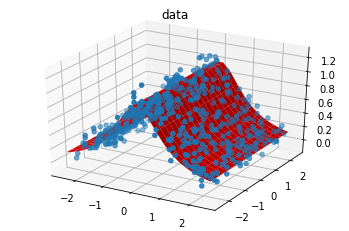

In [114]:
from mpl_toolkits.mplot3d import Axes3D


def f(X):
    return 1 / (1 + (X[:,0])**2) 

SIGMA=0.1
N_train = 500
np.random.seed(0)

X = 5*(np.random.rand(N_train, 2) - 0.5)
y = f(X) + SIGMA*np.random.randn(N_train)

N_plt=20
x_plt = 5*(np.linspace(0, 1, N_plt) - 0.5).reshape(-1,1)
xx, yy = np.meshgrid(x_plt, x_plt)
X_plt = np.c_[xx.ravel(), yy.ravel()]

ax = plt.gca(projection="3d")
ax.plot_surface(xx, yy, f(X_plt).reshape(N_plt, N_plt), color="red")
ax.scatter(X[:,0], X[:,1], y)

plt.title("data")
plt.show()


def plot2D(model, ax):
    model.fit(X, y)
    yhat= model.predict(X_plt)
    if model.adaptive:
        ax.set_title(r"%s,degree=%d,adaptive,$\alpha$=%.1f"%(model.kernel, model.degree, model.alpha))
    else:
        if model == "gaussian":
            ax.set_title(r"%s,degree=%d,non-adaptive,$\gamma$=%.1f"%(model.kernel, model.degree, model.gamma))
        else:
            ax.set_title(r"%s,degree=%d,non-adaptive,$r$=%.1f"%(model.kernel, model.degree, model.radius))
            
    #ax.plot_surface(xx, yy, f(X_plt).reshape(N_plt, N_plt), color="red")
    ax.plot_surface(xx, yy, yhat.reshape(N_plt, N_plt), label="predict")
    

## 非自适应方法

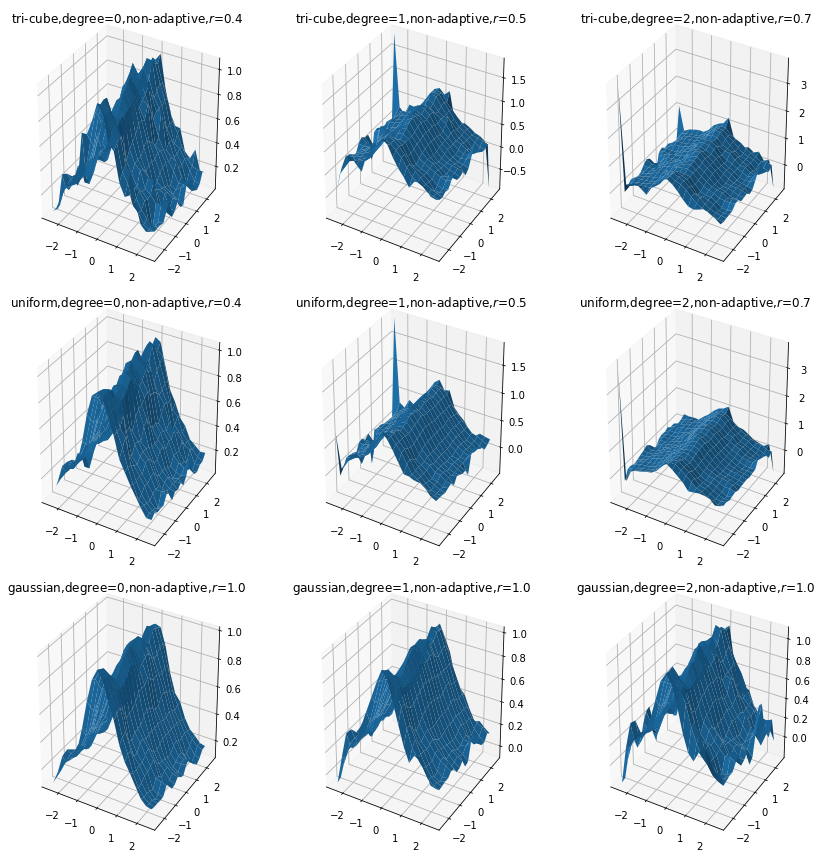

In [115]:
plt.figure(figsize=(12,12))

plot2D(LocalRegressor(degree=0, kernel="tri-cube", radius=0.4), ax = plt.subplot(3,3,1, projection="3d"))
plot2D(LocalRegressor(degree=1, kernel="tri-cube", radius=0.5), ax = plt.subplot(3,3,2, projection="3d"))
plot2D(LocalRegressor(degree=2, kernel="tri-cube", radius=0.7), ax = plt.subplot(3,3,3, projection="3d"))
plot2D(LocalRegressor(degree=0, kernel="uniform", radius=0.4), ax = plt.subplot(3,3,4, projection="3d"))
plot2D(LocalRegressor(degree=1, kernel="uniform", radius=0.5), ax = plt.subplot(3,3,5, projection="3d"))
plot2D(LocalRegressor(degree=2, kernel="uniform", radius=0.7), ax = plt.subplot(3,3,6, projection="3d"))
plot2D(LocalRegressor(degree=0, kernel="gaussian", gamma=10), ax = plt.subplot(3,3,7, projection="3d"))
plot2D(LocalRegressor(degree=1, kernel="gaussian", gamma=10), ax = plt.subplot(3,3,8, projection="3d"))
plot2D(LocalRegressor(degree=2, kernel="gaussian", gamma=10), ax =plt.subplot(3,3,9, projection="3d"))

plt.tight_layout()
plt.show()

## 自适应方法

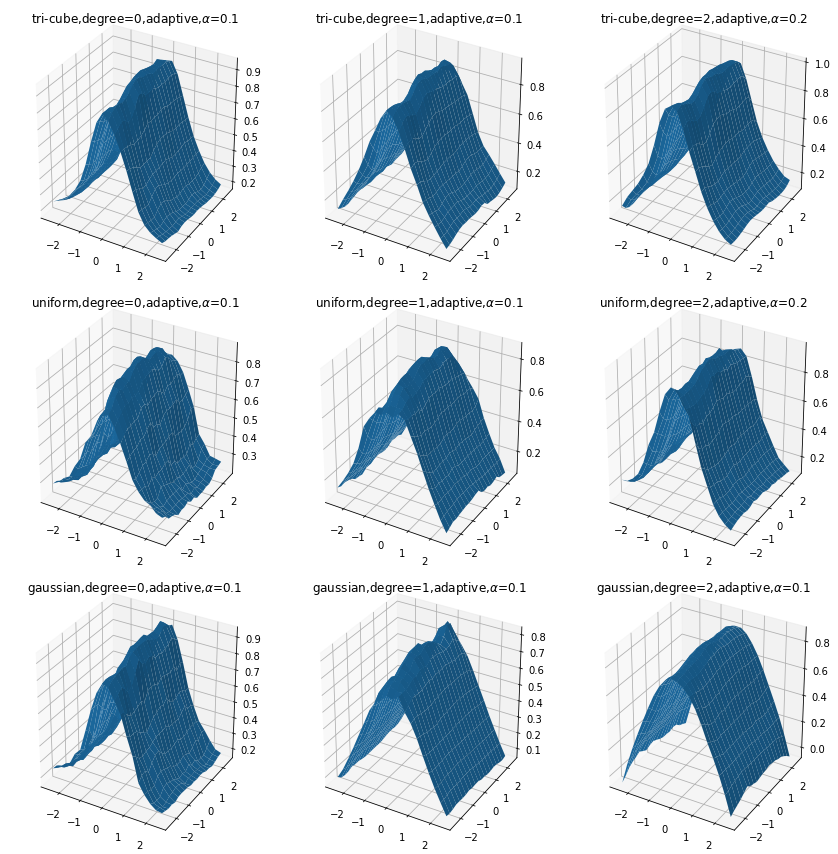

In [116]:
plt.figure(figsize=(12,12))

plot2D(LocalRegressor(degree=0, kernel="tri-cube", adaptive=True, alpha=0.1), ax = plt.subplot(3,3,1, projection="3d"))
plot2D(LocalRegressor(degree=1, kernel="tri-cube", adaptive=True, alpha=0.1), ax = plt.subplot(3,3,2, projection="3d"))
plot2D(LocalRegressor(degree=2, kernel="tri-cube", adaptive=True, alpha=0.2), ax = plt.subplot(3,3,3, projection="3d"))
plot2D(LocalRegressor(degree=0, kernel="uniform", adaptive=True, alpha=0.1), ax = plt.subplot(3,3,4, projection="3d"))
plot2D(LocalRegressor(degree=1, kernel="uniform", adaptive=True, alpha=0.1), ax = plt.subplot(3,3,5, projection="3d"))
plot2D(LocalRegressor(degree=2, kernel="uniform", adaptive=True, alpha=0.2), ax = plt.subplot(3,3,6, projection="3d"))
plot2D(LocalRegressor(degree=0, kernel="gaussian", adaptive=True, alpha=0.05), ax = plt.subplot(3,3,7, projection="3d"))
plot2D(LocalRegressor(degree=1, kernel="gaussian", adaptive=True, alpha=0.05), ax = plt.subplot(3,3,8, projection="3d"))
plot2D(LocalRegressor(degree=2, kernel="gaussian", adaptive=True, alpha=0.1), ax =plt.subplot(3,3,9, projection="3d"))

plt.tight_layout()
plt.show()